In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, Activation, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import os
from functools import reduce
import datetime
import matplotlib.pyplot as plt


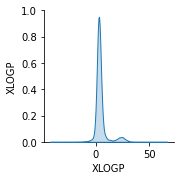

In [4]:
# Use seaborn for pairplot
!pip install -q seaborn

import seaborn as sns

column_names = ['SMILES', 'XLOGP']

df = pd.read_csv("https://raw.githubusercontent.com/manuelr417/charecterlevel/master/sample_training2.csv",
                 names=column_names)

dataset = df.copy()
dataset.tail()
dataset = dataset.dropna()
sns.pairplot(dataset[['XLOGP']], diag_kind='kde')

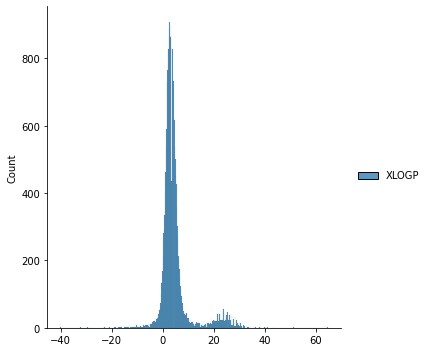

In [5]:
dataset[['XLOGP']].describe().transpose()[['mean', 'std']]

sns.displot(dataset[['XLOGP']])

In [15]:


df = pd.read_csv("https://raw.githubusercontent.com/manuelr417/charecterlevel/master/sample_training2.csv")
texts = df.iloc[:,0].to_list()

tk =  Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(texts)
print(tk.word_index)
print("word index len: ", len(tk.word_index))

sequences = tk.texts_to_sequences(texts)
#print(texts[0])
#print(sequences[0])

lens = [len(x) for i, x in enumerate(sequences)]
#print(lens)
print("max: ", max(lens))
sum_ser = reduce(lambda x, y: x + y, lens)
print("sum ", sum_ser)
avg_len = (sum_ser * 1.0)/(len(lens))
print("avg_len: ", avg_len)

data = pad_sequences(sequences, maxlen=1400, padding='post')


{'UNK': 1, 'c': 2, '=': 3, '(': 4, ')': 5, 'o': 6, 'n': 7, '1': 8, '2': 9, '@': 10, '3': 11, '[': 12, ']': 13, 'h': 14, '4': 15, '/': 16, 'f': 17, '5': 18, 's': 19, '\\': 20, 'l': 21, '6': 22, 'p': 23, '-': 24, '+': 25, '#': 26, '7': 27, 'b': 28, 'r': 29, '8': 30, '9': 31, 'i': 32, '%': 33, '0': 34}
word index len:  34
max:  1185
sum  1370458
avg_len:  60.60487330296732


In [16]:
np_data = np.array(data)
print("Shape X ", np_data.shape)
xlogs = df.iloc[:, 1].to_list()

y_data = np.array(xlogs)

print("Shape Y ", y_data.shape)

Shape X  (22613, 1400)
Shape Y  (22613,)


In [17]:
# Neural net
input_size = 1400
dimension = 50
vocabulary_size = len(tk.word_index)

input_layer = Input(shape=(input_size,), name="input_layer")
embedding_layer = Embedding(vocabulary_size + 1, dimension, input_length=input_size, name="embedding")(input_layer)
num_filters = 64
filter_size = 7

X = Conv1D(num_filters, filter_size, padding='same', name="conv1")(embedding_layer)
X = BatchNormalization()(X)
X = Activation(activation='relu')(X)
#X = MaxPool1D(pool_size=2, name="maxpool1")(conv_1)

num_filters = 64
filter_size = 7


X = Conv1D(num_filters, filter_size, padding='same', name="conv2")(X)
X = BatchNormalization()(X)
X = Activation(activation='relu')(X)
#max_pool2 = MaxPool1D(pool_size=2, name="maxpool2")(conv_2)

num_filters = 64
filter_size = 7


X = Conv1D(num_filters, filter_size, padding='same', name="conv3")(X)
X = BatchNormalization()(X)
X = Activation(activation='relu')(X)
#max_pool3 = MaxPool1D(pool_size=2, name="maxpool3")(conv_3)


X = Flatten()(X)
X = Dense(1024*2, activation='relu', name="dense1")(X)
X = Dense(1024, activation='relu', name="dense2")(X)
X = Dense(512, activation='relu', name="dense3")(X)
X = Dense(512/2, activation='relu', name="dense4")(X)

output = Dense(1, name="dense5")(X)

In [18]:
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mae', metrics=['mse', 'mae']) # Adam, categorical_crossentropy
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1400)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1400, 50)          1750      
_________________________________________________________________
conv1 (Conv1D)               (None, 1400, 64)          22464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1400, 64)          256       
_________________________________________________________________
activation_6 (Activation)    (None, 1400, 64)          0         
_________________________________________________________________
conv2 (Conv1D)               (None, 1400, 64)          28736     
_________________________________________________________________
batch_normalization_7 (Batch (None, 1400, 64)          256 

In [ ]:
model.fit(np_data, y_data, epochs=10, batch_size= 64, validation_split=0.3)

Epoch 1/10
135/248 [===============>..............] - ETA: 2:27 - loss: 12.0412 - mse: 2444.6331 - mae: 12.0412